# Text classification from scratch

**Authors:** Mark Omernick, Francois Chollet<br>
**Date created:** 2019/11/06<br>
**Last modified:** 2020/05/17<br>
**Description:** Text sentiment classification starting from raw text files.

## Introduction

This example shows how to do text classification starting from raw text (as
a set of text files on disk). We demonstrate the workflow on the IMDB sentiment
classification dataset (unprocessed version). We use the `TextVectorization` layer for
 word splitting & indexing.

## Setup

In [1]:
import tensorflow as tf
import numpy as np

## Load the data: IMDB movie review sentiment classification

Let's download the data and inspect its structure.

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  13.8M      0  0:00:05  0:00:05 --:--:-- 16.3M


The `aclImdb` folder contains a `train` and `test` subfolder:

In [3]:
!ls aclImdb

imdbEr.txt  imdb.vocab	README	test  train


In [4]:
!ls aclImdb/test

labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


In [5]:
!ls aclImdb/train

labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


The `aclImdb/train/pos` and `aclImdb/train/neg` folders contain text files, each of
 which represents one review (either positive or negative):

In [6]:
!cat aclImdb/train/pos/6248_7.txt

Being an Austrian myself this has been a straight knock in my face. Fortunately I don't live nowhere near the place where this movie takes place but unfortunately it portrays everything that the rest of Austria hates about Viennese people (or people close to that region). And it is very easy to read that this is exactly the directors intention: to let your head sink into your hands and say "Oh my god, how can THAT be possible!". No, not with me, the (in my opinion) totally exaggerated uncensored swinger club scene is not necessary, I watch porn, sure, but in this context I was rather disgusted than put in the right context.<br /><br />This movie tells a story about how misled people who suffer from lack of education or bad company try to survive and live in a world of redundancy and boring horizons. A girl who is treated like a whore by her super-jealous boyfriend (and still keeps coming back), a female teacher who discovers her masochism by putting the life of her super-cruel "lover" 

We are only interested in the `pos` and `neg` subfolders, so let's delete the rest:

In [8]:
!rm -r aclImdb/train/unsup

rm: cannot remove 'aclImdb/train/unsup': No such file or directory


You can use the utility `tf.keras.preprocessing.text_dataset_from_directory` to
generate a labeled `tf.data.Dataset` object from a set of text files on disk filed
 into class-specific folders.

Let's use it to generate the training, validation, and test datasets. The validation
and training datasets are generated from two subsets of the `train` directory, with 20%
of samples going to the validation dataset and 80% going to the training dataset.

Having a validation dataset in addition to the test dataset is useful for tuning
hyperparameters, such as the model architecture, for which the test dataset should not
be used.

Before putting the model out into the real world however, it should be retrained using all
available training data (without creating a validation dataset), so its performance is maximized.

When using the `validation_split` & `subset` arguments, make sure to either specify a
random seed, or to pass `shuffle=False`, so that the validation & training splits you
get have no overlap.

In [9]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

print(
    "Number of batches in raw_train_ds: %d"
    % tf.data.experimental.cardinality(raw_train_ds)
)
print(
    "Number of batches in raw_val_ds: %d" % tf.data.experimental.cardinality(raw_val_ds)
)
print(
    "Number of batches in raw_test_ds: %d"
    % tf.data.experimental.cardinality(raw_test_ds)
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 625
Number of batches in raw_val_ds: 157
Number of batches in raw_test_ds: 782


Let's preview a few samples:

In [10]:
# It's important to take a look at your raw data to ensure your normalization
# and tokenization will work as expected. We can do that by taking a few
# examples from the training set and looking at them.
# This is one of the places where eager execution shines:
# we can just evaluate these tensors using .numpy()
# instead of needing to evaluate them in a Session/Graph context.
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Decade that actually can make you think. This is one I\'d love to see on the big screen, because even in a widescreen presentation, I don\'t think the overall scope of this film would receive its

## Prepare the data

In particular, we remove `<br />` tags.

In [11]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re

# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )


# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

## Two options to vectorize the data

There are 2 ways we can use our text vectorization layer:

**Option 1: Make it part of the model**, so as to obtain a model that processes raw
 strings, like this:

```python
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
...
```

**Option 2: Apply it to the text dataset** to obtain a dataset of word indices, then
 feed it into a model that expects integer sequences as inputs.

An important difference between the two is that option 2 enables you to do
**asynchronous CPU processing and buffering** of your data when training on GPU.
So if you're training the model on GPU, you probably want to go with this option to get
 the best performance. This is what we will do below.

If we were to export our model to production, we'd ship a model that accepts raw
strings as input, like in the code snippet for option 1 above. This can be done after
 training. We do this in the last section.


In [14]:

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

## Build a model

We choose a simple 1D convnet starting with an `Embedding` layer.

In [16]:
from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512 

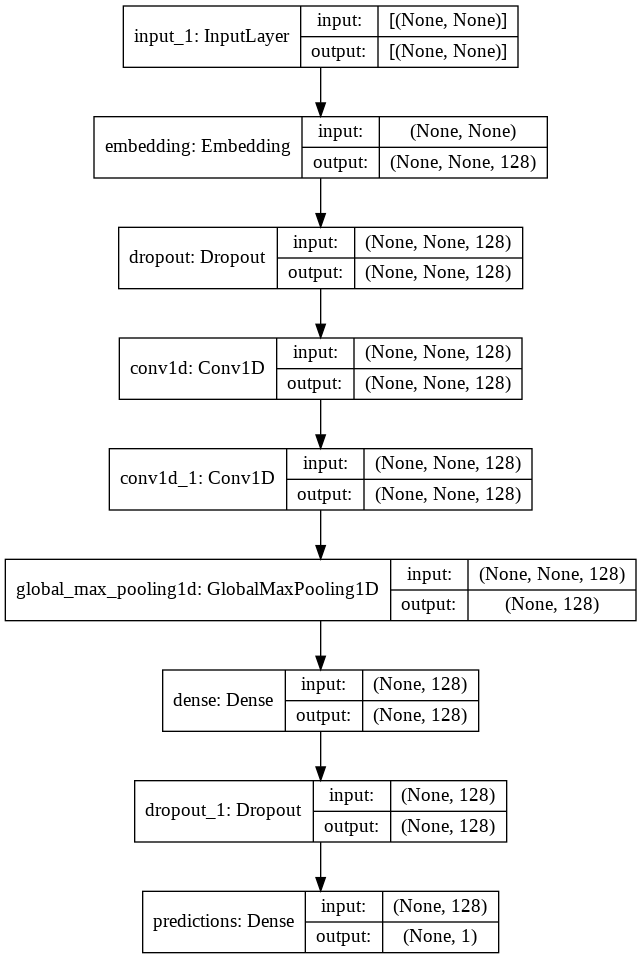

In [18]:
tf.keras.utils.plot_model(model,to_file='TextModel.png',show_shapes=True)

## Train the model

In [19]:
epochs = 3

# Fit the model using the train and test datasets.
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
625/625 [==============================] - 147s 233ms/step - loss: 0.5157 - accuracy: 0.7005 - val_loss: 0.3125 - val_accuracy: 0.8730
Epoch 2/3
625/625 [==============================] - 136s 218ms/step - loss: 0.2275 - accuracy: 0.9107 - val_loss: 0.3283 - val_accuracy: 0.8778
Epoch 3/3
625/625 [==============================] - 136s 218ms/step - loss: 0.1132 - accuracy: 0.9593 - val_loss: 0.4096 - val_accuracy: 0.8740


## Evaluate the model on the test set

In [20]:
model.evaluate(test_ds)

782/782 [==============================] - 38s 48ms/step - loss: 0.4229 - accuracy: 0.8646


[0.42285391688346863, 0.8646399974822998]

## Make an end-to-end model

If you want to obtain a model capable of processing raw strings, you can simply
create a new model (using the weights we just trained):

In [21]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.evaluate(raw_test_ds)

782/782 [==============================] - 40s 51ms/step - loss: 0.4229 - accuracy: 0.8646


[0.42285406589508057, 0.8646399974822998]